# **CSV & Libraries import**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")
file_path = "../data/unique_users_after_labeling.csv"
df = pd.read_csv(file_path)

# Initial data
df.head()


Mounted at /content/drive


,userid,totaltweets,avg_retweetcount,followers,following,acctdesc,label
0,22240612,347147,1.755378,925487,46,The Arab world’s leading source of global news...,0
1,6135622,172270,39.639711,1367996,169,Desde Alemania para América Latina. Todo lo qu...,0
2,848416437030985728,3634,1.000000,47826,261,"Changsha, the capital of central China’s Hunan...",0
3,984429894829592576,16116,0.398857,328,72,"🌐✈Blog de aviación, viajes y economía para via...",0
4,807095565028917248,8325,18.340000,26020,15984,Nature heals. Birding in China: best photos+vi...,0


# **Data Checks**

In [ ]:
# Check relevant columns
df.columns

# total predicted bots
df["label"].value_counts()


,count
label,
0,2324724
1,64955


# **User Split**
**Conclusion:** The vast majority of users were classified as human, while a small but distinct subset was identified as bots, indicating that automated accounts are present but not prevalent in the dataset.

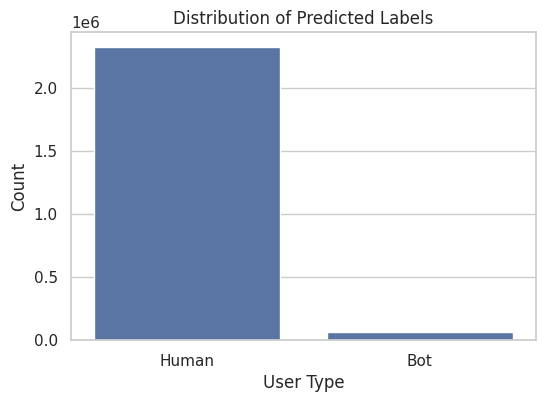

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.xticks([0, 1], ["Human", "Bot"])
plt.title("Distribution of Predicted Labels")
plt.xlabel("User Type")
plt.ylabel("Count")
plt.show()


# **Average Features Comparison for Humans and Bots**
**Conclusion:** On average, human accounts exhibit higher values across all key metrics — including total tweets, retweet count, followers, and following - suggesting greater activity and engagement compared to bot accounts.

In [ ]:
df.groupby("label")[["totaltweets", "avg_retweetcount", "followers", "following"]].mean()


,totaltweets,avg_retweetcount,followers,following
label,,,,
0,18722.549034,406.129959,4613.884333,1045.554498
1,12265.809714,300.742788,1568.636025,918.062212


# **totaltweets split**
**Conclusion:** Most users, especially bots, cluster around mid-range tweet counts, with humans showing a broader and more evenly spread distribution. This suggests that human accounts tend to sustain more diverse and prolonged activity compared to bots.

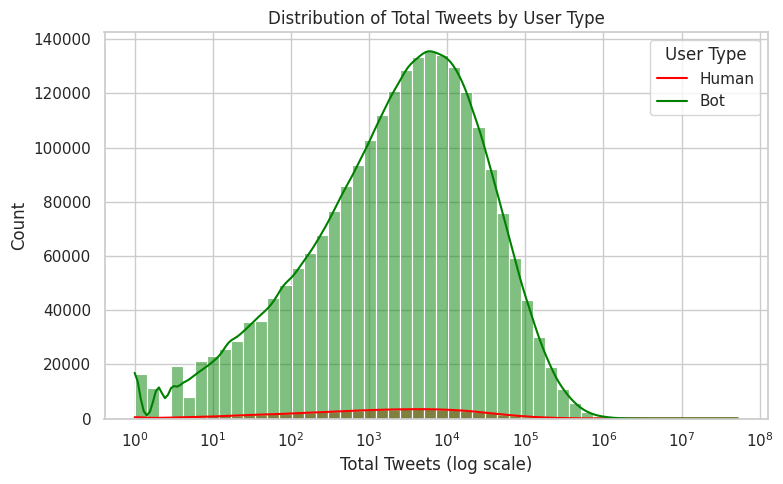

In [ ]:
# Clean
df_clean = df[(df["totaltweets"].notna()) & (df["totaltweets"] > 0)]

plt.figure(figsize=(8,5))
sns.histplot(
    data=df_clean,
    x="totaltweets",
    hue="label",
    bins=50,
    log_scale=True,
    kde=True,
    palette={0: "green", 1: "red"}
)
plt.title("Distribution of Total Tweets by User Type")
plt.xlabel("Total Tweets (log scale)")
plt.legend(title="User Type", labels=["Human", "Bot"])
plt.tight_layout()
plt.show()


# **avg_retweetcount Boxplot**
**Conclusion:** Both humans and bots exhibit a wide range of retweet counts, but human accounts show a higher median and broader spread, indicating more consistent and potentially more impactful engagement.

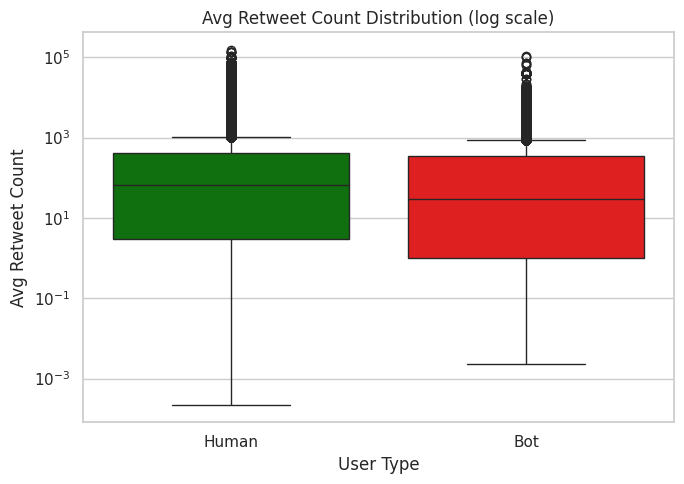

In [ ]:
# Cast
df["label"] = df["label"].astype(int)

# Filter NaNs
df_box = df[df["avg_retweetcount"].notna() & (df["avg_retweetcount"] > 0)]

# Plot
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df_box,
    x="label",
    y="avg_retweetcount",
    hue="label",
    palette={0: "green", 1: "red"},
    legend=False
)
plt.xticks([0,1], ["Human", "Bot"])
plt.yscale("log")
plt.title("Avg Retweet Count Distribution (log scale)")
plt.xlabel("User Type")
plt.ylabel("Avg Retweet Count")
plt.tight_layout()
plt.show()


# **Followers vs. Following Scatter Graph**
**Conclusion:** Most accounts cluster at low follower and following counts, with a few human users reaching exceptionally high follower numbers. Bots are sparsely distributed and generally occupy the lower influence space, suggesting limited social reach.

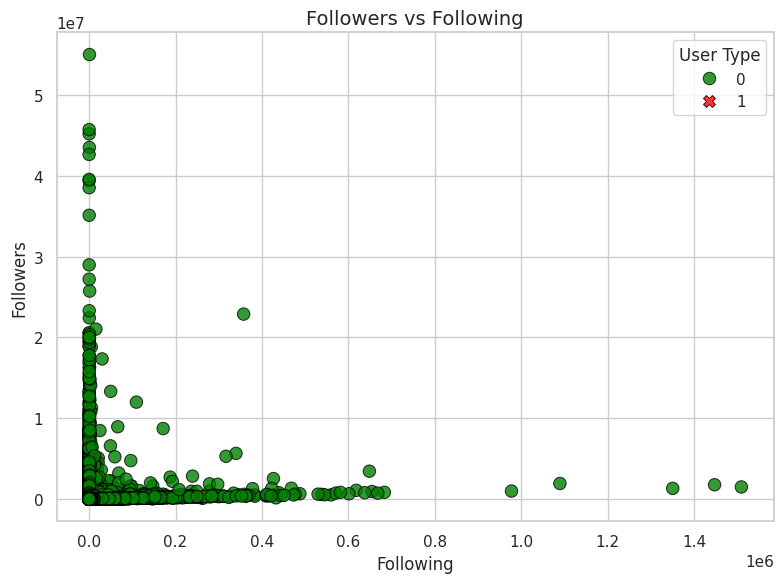

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="following",
    y="followers",
    hue="label",
    palette={0: "green", 1: "red"},
    style="label",
    markers={0: "o", 1: "X"},
    s=80,
    edgecolor="black",
    alpha=0.8
)

plt.title("Followers vs Following", fontsize=14)
plt.xlabel("Following", fontsize=12)
plt.ylabel("Followers", fontsize=12)
plt.legend(title="User Type", loc="upper right")
plt.tight_layout()
plt.show()


# **Followers / Following Ratio**
**Conclusion:** Most accounts, especially bots, have low follower-to-following ratios, typically below 1, indicating that they follow many users but receive few followers in return — a common behavioral marker of automated or low-trust accounts.

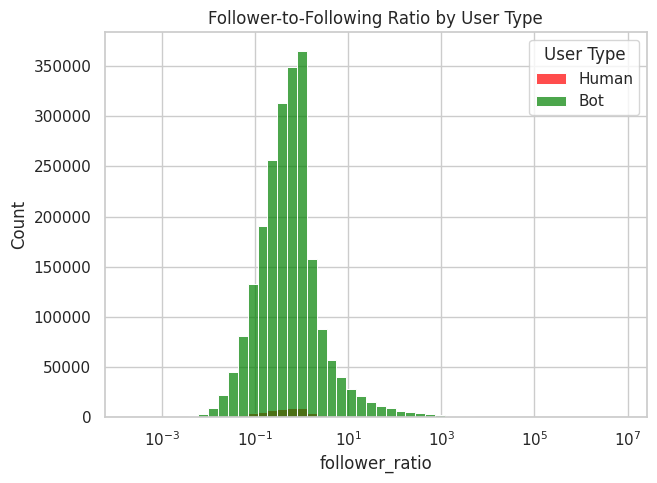

In [ ]:
df["follower_ratio"] = df["followers"] / (df["following"] + 1)

plt.figure(figsize=(7,5))
sns.histplot(data=df, x="follower_ratio", hue="label", bins=50, log_scale=True, palette={0: "green", 1: "red"}, alpha=0.7)
plt.title("Follower-to-Following Ratio by User Type")
plt.legend(title="User Type", labels=["Human", "Bot"])
plt.show()


# **Features Heatmap**
**Conclusion:** The heatmap reveals weak correlations between most features, with the strongest being between followers and follower_ratio (0.26). This suggests that the features used are largely independent, which is beneficial for a classification model as it reduces redundancy and encourages diverse signal contribution.

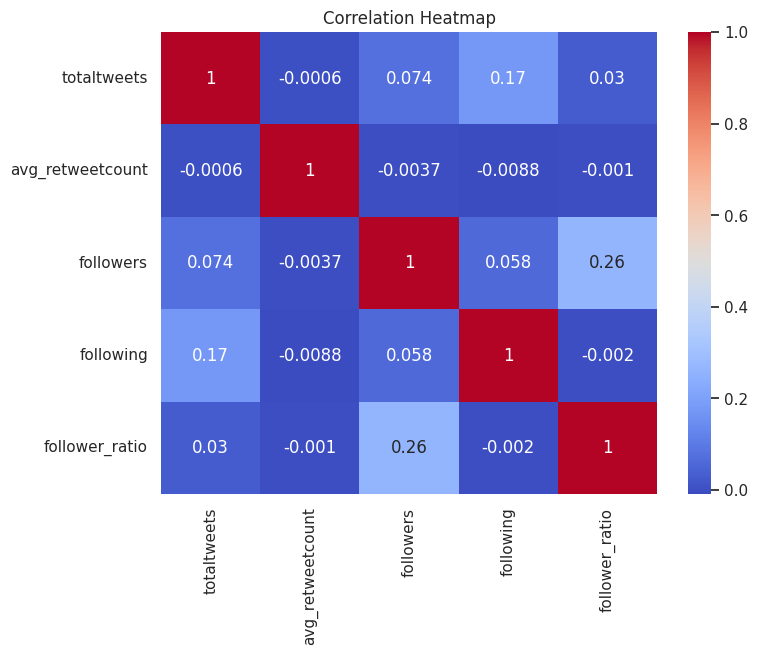

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["totaltweets", "avg_retweetcount", "followers", "following", "follower_ratio"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# **20 Most Common Words Per Label**
**Conclusion:** Human account descriptions commonly include expressive and personal terms such as “love,” “life,” “fan,” and “music,” reflecting identity and interests. In contrast, bot descriptions frequently contain business and tech-related terms like “crypto,” “trader,” “nft,” and “marketing,” suggesting a focus on promotion, automation, or commercial messaging rather than genuine social interaction.

In [ ]:
from collections import Counter
import pandas as pd
import re

# Clean text
def get_top_words(text, stopwords=set(), n=20):
    # Clean numbers and symbols
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    filtered_words = [word for word in words if word not in stopwords and len(word) > 2]
    return Counter(filtered_words).most_common(n)

# Stopwords
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

# Texts
text_humans = " ".join(df[df["label"] == 0]["acctdesc"].dropna().astype(str))
text_bots = " ".join(df[df["label"] == 1]["acctdesc"].dropna().astype(str))

# Count
top_human_words = get_top_words(text_humans, stopwords)
top_bot_words = get_top_words(text_bots, stopwords)

# Plot
df_top_human = pd.DataFrame(top_human_words, columns=["Word", "Count"]).reset_index(drop=True)
df_top_bot = pd.DataFrame(top_bot_words, columns=["Word", "Count"]).reset_index(drop=True)

print("🔹 Top 20 Human Description Words")
display(df_top_human)

print("🔹 Top 20 Bot Description Words")
display(df_top_bot)


🔹 Top 20 Human Description Words


,Word,Count
0,https,139495
1,love,60323
2,life,44901
3,fan,44883
4,world,38724
5,que,38015
6,news,33825
7,lover,30238
8,follow,29417
9,music,29281


🔹 Top 20 Bot Description Words


,Word,Count
0,https,3943
1,crypto,2629
2,world,1658
3,news,1630
4,trader,1391
5,nft,1300
6,life,1193
7,business,1192
8,digital,1146
9,media,1122


# **Summary**

## **General Observations**
- The vast majority of user accounts were classified as human, while a small but noticeable subset was identified as bots.
- This reflects the presence of automated accounts in the dataset, though they remain a minority compared to human users.

## **Behavioral Feature Analysis**

#### **Tweet Volume (`totaltweets`)**
- Most users, including bots, are concentrated in mid-range tweet counts.
- Human accounts show a wider and more evenly spread distribution, suggesting longer-term or more sustained engagement.

#### **Average Retweet Count (`avg_retweetcount`)**
- Human accounts have a higher median and broader distribution of retweet counts.
- Bot accounts tend to receive fewer retweets, indicating limited impact or influence on user engagement.

#### **Followers vs Following**
- Most accounts cluster at low follower and following counts, with a few human outliers reaching extremely high follower numbers.
- Bots generally occupy the lower end of the social graph, showing limited organic reach.

#### **Follower-to-Following Ratio**
- Bots are strongly concentrated in low follower-to-following ratios, often below 1.
- Human accounts demonstrate more balanced ratios, reinforcing this metric as a useful signal for bot detection.

## **Feature Correlation**
- All numerical features show weak correlations, with the strongest being between `followers` and `follower_ratio` (~0.26).
- This indicates that the features contribute independently to the classification task, supporting model robustness.

## **Textual Analysis: Account Descriptions**

### **Human Descriptions**
- Include expressive, personal, and interest-driven words such as:  
  "love", "life", "music", "fan", "proud", "writer", "god".
- Frequent appearance of "https" indicates use of personal or content-sharing links.

### **Bot Descriptions**
- Focused on commercial and technical keywords including:  
  "crypto", "trader", "nft", "marketing", "business", "digital".
- Also frequently contain "https", suggesting a tendency toward external promotion or automation.

## **Conclusions**
- Bots in the dataset display clear behavioral and textual differences from human users.
- Key indicators include: lower social reach, fewer retweets, imbalanced follower patterns, and keyword-heavy commercial descriptions.
- These differences support the effectiveness of using a hybrid classification approach, combining metadata and text-based features, to detect bots at scale — particularly in contexts involving social manipulation or information warfare.


In [ ]:
summary = df.groupby("label")[["totaltweets", "avg_retweetcount", "followers", "following"]].agg(['mean', 'median', 'std'])
summary


totaltweets                       avg_retweetcount            \
               mean  median           std             mean    median   
label                                                                  
0      18722.549034  3017.0  66831.055857       406.129959  0.666667   
1      12265.809714  1630.0  39909.796322       300.742788  0.000000   

                      followers                          following         \
               std         mean median            std         mean median   
label                                                                       
0      2194.215079  4613.884333  168.0  142167.748967  1045.554498  320.0   
1      1863.480644  1568.636025  126.0   17742.237713   918.062212  246.0   

                    
               std  
label               
0      4366.443844  
1      3120.275029

# **Key Research Conclusions**

**Research Question:** How do bots influence social discourse during the Russia–Ukraine war?

1. **Bots are present but remain a minority**
While bots account for only a small portion of the total user base, their consistent presence highlights an underlying layer of automated activity within the wartime discourse.

2. **Bots display distinct and less active behavioral profiles**
Bots have fewer total tweets, lower average retweet counts, and significantly fewer followers than human users. These patterns suggest reduced engagement and visibility, possibly due to artificial or one-sided activity.

3. **Follower dynamics suggest low authenticity**
Bots commonly maintain low follower-to-following ratios, following many accounts while gaining few followers in return — a strong indicator of inauthentic or automated behavior.

4. **Textual signals indicate promotional and ideological targeting**
Bot profiles frequently include commercial and tech-related keywords such as “crypto,” “nft,” “trader,” and “marketing,” contrasting with human accounts that focus on personal interests and identity. This suggests an intent to blend into discourse for promotional or manipulative purposes.

5. **Bots contribute more through content injection than interaction**
Although bots do not appear to drive high engagement, their strategy seems to focus on amplifying specific narratives or content types. This aligns with tactics seen in propaganda and coordinated disinformation campaigns.

6. **Influence is better understood through content patterns than volume**
The influence of bots is not primarily measured in quantity but in the kind of messaging they introduce into the public sphere — especially in politically sensitive and emotionally charged contexts like the Russia–Ukraine war.
